# Figure: XOR Visualization
## Ground Truth vs Prediction Comparison

This notebook generates XOR visualization comparing ground truth annotations with model predictions.

In [ ]:
# =============================================================================
# Figure 3: XOR Visualization Setup and Imports
# =============================================================================

# Import required libraries for image processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.io import imread
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment

# Configure matplotlib for publication-quality plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

print("Figure 3 XOR Visualization - Libraries imported successfully")

/vf/users/sagarm2/miniconda38/envs/cellposeChr/lib/python3.8/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


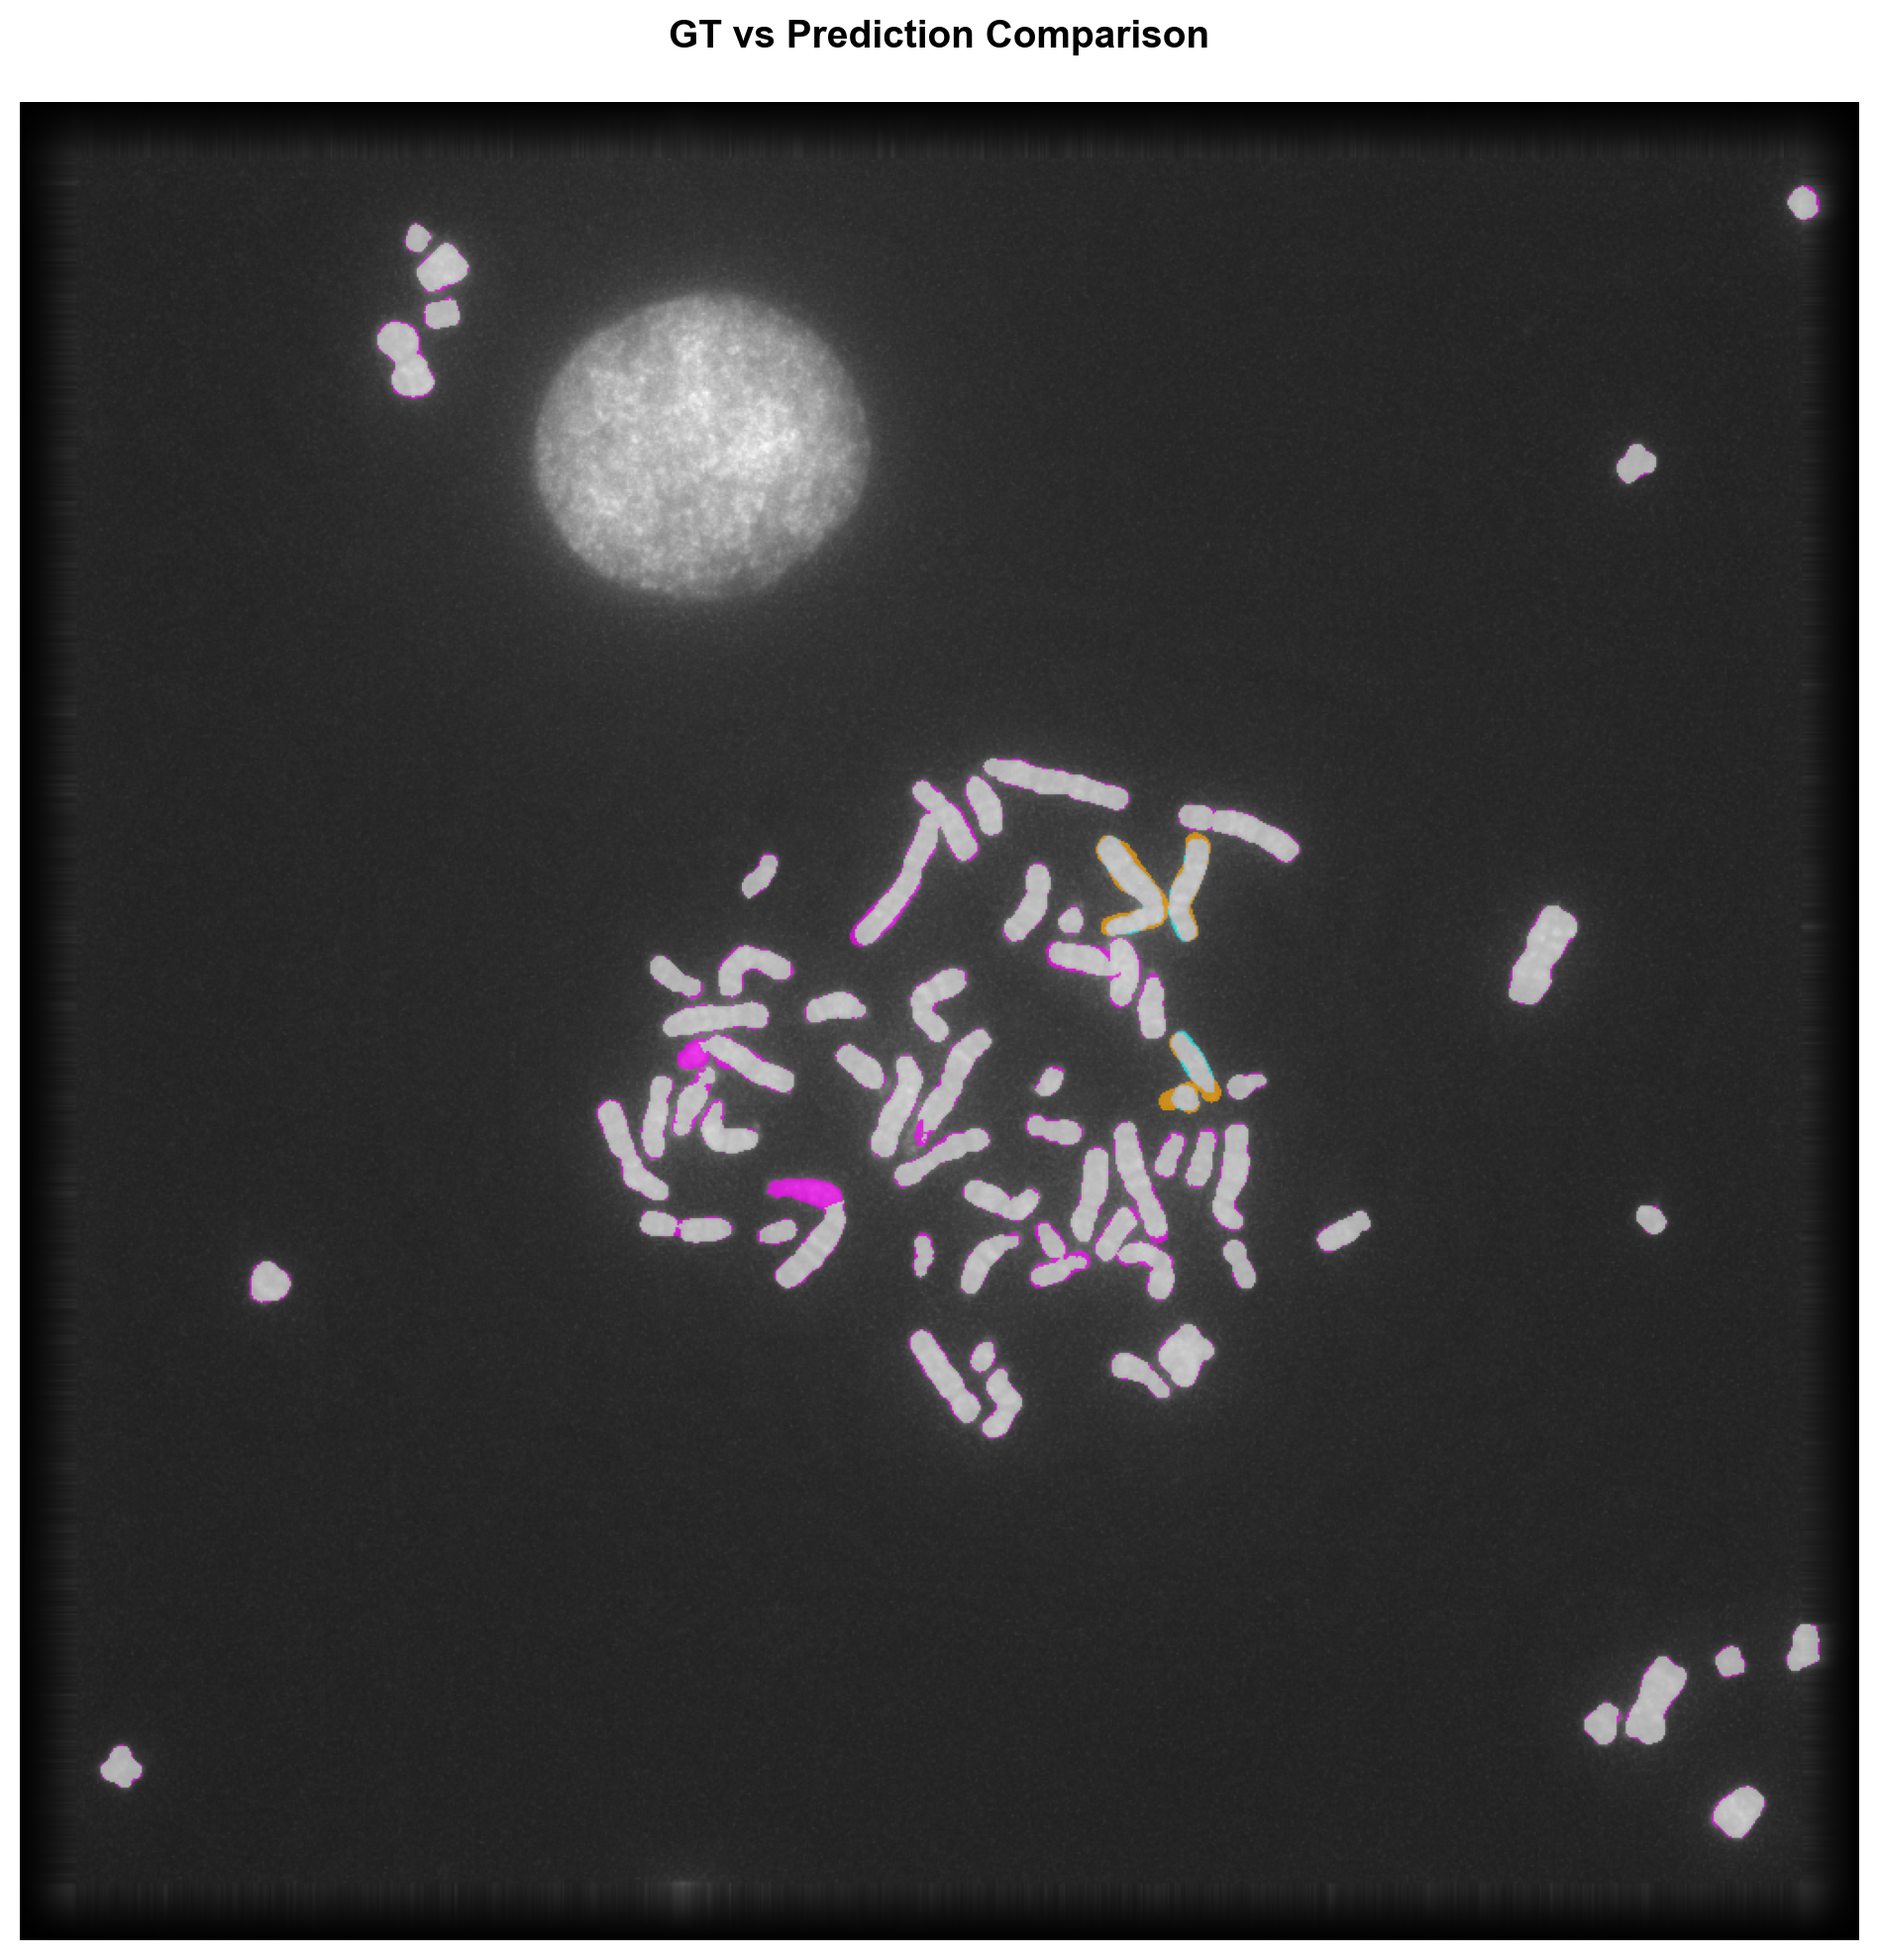


Pixel-level Statistics:
Correct pixels: 34,036 (3.2%)
False Positive pixels: 1,432 (0.1%)
False Negative pixels: 3,208 (0.3%)
Pixel-level differences: 4,004 (0.4%)
Total accuracy: 99.6%


In [ ]:
# =============================================================================
# Figure 3: Comprehensive XOR Visualization Analysis
# =============================================================================
# This code creates a sophisticated comparison between ground truth annotations
# and model predictions using color-coded overlays on the original image.
# It implements advanced object matching and pixel-level difference detection.

# =============================================================================
# Step 1: Load Input Images
# =============================================================================
print("Loading images for XOR analysis...")

# Load the original microscopy image (base image for visualization)
originalImage = imread('/vf/users/sagarm2/cellpose_chr/PaperData/figure3/results/image_01_original.tif')    

# Load ground truth segmentation mask (expert annotations)
ground_truth_original = imread('/vf/users/sagarm2/cellpose_chr/PaperData/figure3/results/mask_original_image_01.tif')

# Load prediction mask from selected model
# Options available (uncomment the one you want to use):
# pred = imread('/vf/users/sagarm2/cellpose_chr/PaperData/figure3/results/image_01_Watershed.tif') # watershed
# pred = imread('/vf/users/sagarm2/cellpose_chr/PaperData/figure3/results/image_01_cp.tif') # cellpose_default
pred = imread('/vf/users/sagarm2/cellpose_chr/PaperData/figure3/results/mask_0_cellpose_retained_1.png') # cellpose_retrained

print(f"Original image shape: {originalImage.shape}")
print(f"Ground truth shape: {ground_truth_original.shape}")
print(f"Prediction shape: {pred.shape}")

# =============================================================================
# Step 2: Convert Masks to Binary Format
# =============================================================================
# Convert segmentation masks to binary (0=background, 1=foreground)
# This standardizes different mask formats for comparison
gt_binary = ground_truth_original > 0
pred_binary = pred > 0

print(f"Ground truth objects detected: {np.sum(gt_binary > 0)}")
print(f"Predicted objects detected: {np.sum(pred_binary > 0)}")

# =============================================================================
# Step 3: Create Basic Pixel-Level Classification Masks
# =============================================================================
# These represent the four fundamental outcomes of binary classification:

# True Positive: Pixels correctly identified as foreground (GT ∩ Prediction)
correct_mask = np.logical_and(gt_binary, pred_binary)

# False Positive: Pixels incorrectly identified as foreground (Prediction only)
false_positive_mask = np.logical_and(~gt_binary, pred_binary)

# False Negative: Pixels incorrectly identified as background (GT only)
false_negative_mask = np.logical_and(gt_binary, ~pred_binary)

# True Negative: Pixels correctly identified as background
background_mask = np.logical_and(~gt_binary, ~pred_binary)

print(f"Basic classification masks created:")
print(f"  True Positives: {np.sum(correct_mask)} pixels")
print(f"  False Positives: {np.sum(false_positive_mask)} pixels")
print(f"  False Negatives: {np.sum(false_negative_mask)} pixels")

# =============================================================================
# Step 4: Advanced Object-Level Matching Analysis
# =============================================================================
# This section performs sophisticated object-to-object matching using IoU
# (Intersection over Union) to identify corresponding objects between GT and prediction

print("Performing object-level matching analysis...")

# Define IoU threshold for considering objects as "matched"
# Objects with IoU >= 0.5 are considered the same object with minor differences
iou_threshold = 0.5

# Label connected components (individual objects) in both masks
# This converts binary masks into labeled images where each object gets a unique ID
gt_labeled = label(gt_binary)
pred_labeled = label(pred_binary)

# Extract properties of each labeled object (bounding box, area, etc.)
gt_props = regionprops(gt_labeled)
pred_props = regionprops(pred_labeled)

print(f"Ground truth objects found: {len(gt_props)}")
print(f"Predicted objects found: {len(pred_props)}")

# =============================================================================
# Step 5: Calculate IoU Matrix for Object Matching
# =============================================================================
# Build a matrix where entry (i,j) contains IoU between GT object i and predicted object j

if len(gt_props) > 0 and len(pred_props) > 0:
    # Initialize IoU matrix
    iou_matrix = np.zeros((len(gt_props), len(pred_props)))
    
    print("Calculating IoU matrix for object matching...")
    
    # Calculate IoU between every pair of GT and predicted objects
    for i, gt_region in enumerate(gt_props):
        # Get mask for this GT object
        gt_mask = (gt_labeled == gt_region.label)
        
        for j, pred_region in enumerate(pred_props):
            # Get mask for this predicted object
            pred_mask = (pred_labeled == pred_region.label)
            
            # Calculate Intersection over Union (IoU)
            # IoU = |A ∩ B| / |A ∪ B|
            intersection = np.logical_and(gt_mask, pred_mask).sum()
            union = np.logical_or(gt_mask, pred_mask).sum()
            iou_matrix[i, j] = intersection / union if union > 0 else 0
    
    # =============================================================================
    # Step 6: Optimal Object Assignment Using Hungarian Algorithm
    # =============================================================================
    # Find the best one-to-one matching between GT and predicted objects
    # This solves the assignment problem to maximize total IoU
    
    # Use Hungarian algorithm for optimal assignment (minimize cost = maximize IoU)
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)  # Negative because we want to maximize
    
    print(f"Optimal object matching found:")
    matched_pairs = 0
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            matched_pairs += 1
            print(f"  GT object {i+1} ↔ Pred object {j+1} (IoU: {iou_matrix[i, j]:.3f})")
    
    print(f"Total matched pairs: {matched_pairs}")
    
    # =============================================================================
    # Step 7: Detect Pixel-Level Differences in Matched Objects
    # =============================================================================
    # For objects that are considered "matched" (IoU >= threshold), identify
    # pixel-level differences to show fine-grained segmentation accuracy
    
    print("Detecting pixel-level differences in matched objects...")
    
    # Initialize mask for pixel-level differences within matched objects
    pixel_diff_mask = np.zeros_like(gt_binary, dtype=bool)
    
    # Process each matched pair that meets the IoU threshold
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            # Get masks for this matched pair
            gt_obj_mask = (gt_labeled == gt_props[i].label)
            pred_obj_mask = (pred_labeled == pred_props[j].label)
            
            # Find the union of both objects (all pixels covered by either object)
            union_mask = np.logical_or(gt_obj_mask, pred_obj_mask)
            
            # Find pixel-level differences within this union
            # XOR operation identifies pixels that belong to one object but not both
            pixel_differences = np.logical_and(
                union_mask,  # Only within the union of both objects
                np.logical_xor(gt_obj_mask, pred_obj_mask)  # Pixels in one but not both
            )
            
            # Add these differences to the overall pixel difference mask
            pixel_diff_mask = np.logical_or(pixel_diff_mask, pixel_differences)
    
    print(f"Pixel-level differences detected: {np.sum(pixel_diff_mask)} pixels")
    
else:
    # Handle case where no objects are found in one or both images
    print("Warning: No objects found for matching analysis")
    pixel_diff_mask = np.zeros_like(gt_binary, dtype=bool)

# =============================================================================
# Step 8: Prepare Base Image for Overlay Visualization
# =============================================================================
# Convert the original microscopy image to RGB format for color overlay

print("Preparing base image for color overlay...")

# Convert grayscale to RGB if necessary
if originalImage.ndim == 2:
    # Stack grayscale image to create RGB
    base_image = np.stack([originalImage]*3, axis=-1)
else:
    # Already RGB, just copy
    base_image = originalImage.copy()

# Normalize pixel values to [0, 1] range for proper color mixing
base_image = base_image.astype(float)
if base_image.max() > 1:
    base_image = base_image / base_image.max()

print(f"Base image prepared: shape {base_image.shape}, range [{base_image.min():.3f}, {base_image.max():.3f}]")

# =============================================================================
# Step 9: Define Color Scheme for XOR Visualization
# =============================================================================
# Create a color-coded overlay following publication standards:
# - Light Gray: Correct segmentation (GT ∩ Prediction)
# - Cyan: False Positives (Prediction only - model over-segmented)
# - Orange: False Negatives (GT only - model under-segmented)  
# - Magenta: Pixel-level differences in matched objects (fine-grained errors)

overlay = base_image.copy()

# Define colors (RGB values normalized to [0, 1])
colors = {
    "correct": [0.827, 0.827, 0.827],      # Light Gray - Correct (GT ∩ Prediction)
    "false_positive": [0.0, 1.0, 1.0],     # Cyan - False Positive (Prediction only)  
    "false_negative": [1.0, 0.647, 0.0],   # Orange - False Negative (GT only)
    "pixel_diff": [1.0, 0.0, 1.0],         # Magenta - Pixel-level differences in matched objects
    "background": None  # Keep original image unchanged
}

# Set transparency level for color overlay
alpha = 0.7  # 70% color, 30% original image for good visibility

print("Applying color-coded overlay...")

# =============================================================================
# Step 10: Apply Color Coding with Priority System
# =============================================================================
# Apply colors in order of priority (pixel differences have highest priority)
# This ensures that the most informative visualization is displayed

# False Positive regions (Prediction only) - Cyan
# These show where the model detected objects that don't exist in ground truth
if np.any(false_positive_mask):
    # Apply color only where there are no pixel differences (lower priority)
    mask_to_color = np.logical_and(false_positive_mask, ~pixel_diff_mask)
    overlay[mask_to_color] = (1 - alpha) * overlay[mask_to_color] + alpha * np.array(colors["false_positive"])
    print(f"  Applied cyan to {np.sum(mask_to_color)} false positive pixels")

# False Negative regions (GT only) - Orange
# These show where the model missed objects that exist in ground truth
if np.any(false_negative_mask):
    mask_to_color = np.logical_and(false_negative_mask, ~pixel_diff_mask)
    overlay[mask_to_color] = (1 - alpha) * overlay[mask_to_color] + alpha * np.array(colors["false_negative"])
    print(f"  Applied orange to {np.sum(mask_to_color)} false negative pixels")

# Correct regions (GT ∩ Prediction) - Light Gray
# These show where both ground truth and prediction agree
if np.any(correct_mask):
    mask_to_color = np.logical_and(correct_mask, ~pixel_diff_mask)
    overlay[mask_to_color] = (1 - alpha) * overlay[mask_to_color] + alpha * np.array(colors["correct"])
    print(f"  Applied light gray to {np.sum(mask_to_color)} correct pixels")

# Pixel-level differences in matched objects - Magenta (highest priority)
# These show fine-grained segmentation differences within correctly detected objects
if np.any(pixel_diff_mask):
    overlay[pixel_diff_mask] = (1 - alpha) * overlay[pixel_diff_mask] + alpha * np.array(colors["pixel_diff"])
    print(f"  Applied magenta to {np.sum(pixel_diff_mask)} pixel difference pixels")

# =============================================================================
# Step 11: Create Publication-Quality Visualization
# =============================================================================
print("Creating final visualization...")

# Create high-resolution figure
plt.figure(figsize=(12, 10), dpi=200)
plt.imshow(overlay)
plt.axis('off')  # Remove axes for clean presentation

# Optional: Add legend (currently commented out for cleaner appearance)
# Uncomment the following lines if you want to include a legend:
'''
# Create custom legend explaining the color scheme
legend_elements = [
    mpatches.Patch(facecolor=colors["correct"], edgecolor='black', label='Correct (GT ∩ Prediction)'),
    mpatches.Patch(facecolor=colors["false_positive"], edgecolor='black', label='False Positive (Prediction only)'),
    mpatches.Patch(facecolor=colors["false_negative"], edgecolor='black', label='False Negative (GT only)'),
    mpatches.Patch(facecolor=colors["pixel_diff"], edgecolor='black', label='Pixel-level differences')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
'''

# Add title with professional formatting
plt.title('Ground Truth vs Prediction Comparison', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# =============================================================================
# Step 12: Generate Comprehensive Statistical Summary
# =============================================================================
print("\n" + "="*60)
print("COMPREHENSIVE XOR ANALYSIS RESULTS")
print("="*60)

# Calculate pixel-level statistics
total_pixels = gt_binary.size
correct_pixels = np.sum(correct_mask)
fp_pixels = np.sum(false_positive_mask)
fn_pixels = np.sum(false_negative_mask)
pixel_diff_pixels = np.sum(pixel_diff_mask)
background_pixels = np.sum(background_mask)

print(f"\nPixel-Level Classification Results:")
print(f"  Total pixels in image: {total_pixels:,}")
print(f"  Correct pixels (TP): {correct_pixels:,} ({100*correct_pixels/total_pixels:.1f}%)")
print(f"  False Positive pixels: {fp_pixels:,} ({100*fp_pixels/total_pixels:.1f}%)")
print(f"  False Negative pixels: {fn_pixels:,} ({100*fn_pixels/total_pixels:.1f}%)")
print(f"  Pixel-level differences: {pixel_diff_pixels:,} ({100*pixel_diff_pixels/total_pixels:.1f}%)")
print(f"  Background pixels (TN): {background_pixels:,} ({100*background_pixels/total_pixels:.1f}%)")

# Calculate standard evaluation metrics
precision = correct_pixels / (correct_pixels + fp_pixels) if (correct_pixels + fp_pixels) > 0 else 0
recall = correct_pixels / (correct_pixels + fn_pixels) if (correct_pixels + fn_pixels) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (correct_pixels + background_pixels) / total_pixels

print(f"\nStandard Evaluation Metrics:")
print(f"  Pixel-level Accuracy: {100*accuracy:.1f}%")
print(f"  Precision: {100*precision:.1f}%")
print(f"  Recall: {100*recall:.1f}%")
print(f"  F1 Score: {100*f1_score:.1f}%")

# Object-level statistics
if len(gt_props) > 0 or len(pred_props) > 0:
    print(f"\nObject-Level Analysis:")
    print(f"  Ground truth objects: {len(gt_props)}")
    print(f"  Predicted objects: {len(pred_props)}")
    if len(gt_props) > 0 and len(pred_props) > 0:
        matched_objects = sum(1 for i, j in zip(row_ind, col_ind) if iou_matrix[i, j] >= iou_threshold)
        print(f"  Successfully matched objects: {matched_objects}")
        print(f"  Object detection rate: {100*matched_objects/len(gt_props):.1f}%")

print(f"\nAnalysis complete! XOR visualization shows:")
print(f"  • Light Gray: Areas where GT and prediction agree")
print(f"  • Cyan: Over-segmentation (false positives)")
print(f"  • Orange: Under-segmentation (false negatives)")
print(f"  • Magenta: Fine-grained differences in matched objects")

In [ ]:
# =============================================================================
# Save Figure 3 and Provide Usage Instructions
# =============================================================================

# Save the visualization in multiple formats for publication
output_dir = '/vf/users/sagarm2/cellpose_chr/'

# Save as high-resolution PNG
plt.savefig(f'{output_dir}Figure3_XOR_Comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white', 
            edgecolor='none', transparent=False)

# Save as vector PDF for publications
plt.savefig(f'{output_dir}Figure3_XOR_Comparison.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', transparent=False)

print("✅ Figure 3 saved successfully!")
print(f"   📁 PNG: {output_dir}Figure3_XOR_Comparison.png")
print(f"   📁 PDF: {output_dir}Figure3_XOR_Comparison.pdf")

print("\n" + "="*60)
print("FIGURE 3 USAGE INSTRUCTIONS")
print("="*60)

print("\n🔧 To analyze different models:")
print("   1. Modify the 'pred' variable in Step 1 to load different prediction masks")
print("   2. Available options are commented in the code:")
print("      • Watershed segmentation")
print("      • Default Cellpose model") 
print("      • Retrained Cellpose model (currently active)")

print("\n🎨 To customize the color scheme:")
print("   1. Modify the 'colors' dictionary in Step 9")
print("   2. Adjust the 'alpha' value to change overlay transparency")
print("   3. Colors are in RGB format normalized to [0,1]")

print("\n📊 To adjust object matching sensitivity:")
print("   1. Change 'iou_threshold' in Step 4")
print("   2. Higher values (0.7-0.9) = stricter matching")
print("   3. Lower values (0.3-0.5) = more lenient matching")

print("\n📐 Understanding the visualization:")
print("   • Light Gray: Perfect agreement between GT and prediction")
print("   • Cyan: Model over-segmentation (detected non-existent objects)")
print("   • Orange: Model under-segmentation (missed real objects)")
print("   • Magenta: Fine-grained boundary differences in matched objects")

print("\n💡 Interpretation tips:")
print("   • Large cyan areas → Model is too sensitive (reduce detection threshold)")
print("   • Large orange areas → Model is too conservative (increase sensitivity)")
print("   • Lots of magenta → Good object detection but poor boundary accuracy")
print("   • Mostly light gray → Excellent segmentation performance")

print("\n📈 Key metrics to report:")
print("   • Pixel-level accuracy: Overall segmentation quality")
print("   • Object detection rate: Ability to find all objects")
print("   • Precision/Recall: Balance between over- and under-segmentation")
print("   • F1 Score: Harmonic mean of precision and recall")

print("\nFigure 3 XOR Analysis Complete! 🎉")